# All the things we learned, in order

#### Or, what the notebook that you publish looks like

First, keep track of the date!

In [1]:
from datetime import date
print(date.today())

2023-06-16


Import necessary libraries. We are going to use `scanpy` for the single-cell portions, `pandas` for table I/O, `numpy` for numerical operations, `seaborn` and `matplotlib` for visualisation, and the `R` package `ape` for the cell type tree.

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc

Before doing anything else, we need to set a random seed for reproducibility purposes:

In [3]:
import random
random.seed(42)

Read in the dataset and its accompanying metadata:

In [4]:
# base dir
data_loc = "/Users/npapadop/Downloads/spongilla_basic.h5ad"
# AnnData object
adata = sc.read_h5ad(data_loc)
# # annotation, in form of a CSV file
# annot = pd.read_csv(data_loc + "pbmc3k_annot.csv", index_col=0)
# # add annotation to .obs slot by joining on the cell barcode index
# adata.obs = adata.obs.join(annot)

### 1. Preprocessing

We are going to normalise the data by the amount of total counts, scale up to the median, apply the log1p transformation for variance stabilisation, and calculate some QC stats.

We are _not_ going to perform QC here. This is out of scope 

In [5]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

Before anything, let's keep track of the raw counts in the `.raw` slot. This way, we can use them to calculate differential expression later.

In [6]:
adata.raw = adata

By setting `target_sum` to `None` when normalising, we explicitly choose to scale to the median. This is considered to be gentler than CPM or CP10k, which add pseudocounts of higher impact to lowly expressed genes (citation needed).

In [7]:
sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata)

We will also calculate highly variable genes and only use those for distance calculations, in an effort to increase our signal-noise ratio.

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

### 2. Distance calculations and dimensionality reduction

We will reduce the dimensionality using PCA. We will choose the number of informative components via a scree plot of explained variance. We will then calculate pairwise cell similarities and nearest neighbors from the PCA embedding. These neighborhoods will then be used to produce a UMAP for visualisation and clustering assignments.

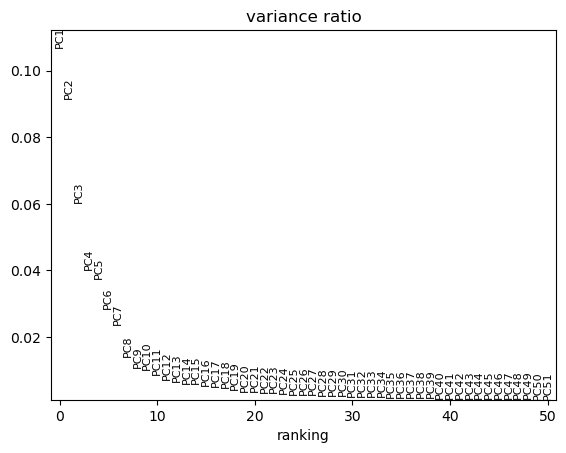

In [9]:
sc.pp.pca(adata, n_comps=100, zero_center=True, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [10]:
sc.pp.neighbors(adata, n_pcs=50, metric="cosine")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packag

We are going to create a UMAP for visualisation purposes:

In [11]:
sc.tl.umap(adata)

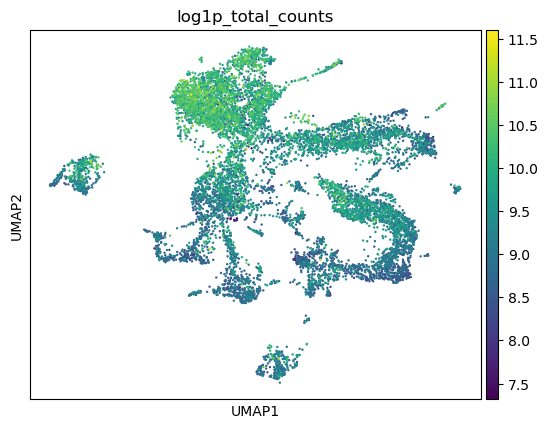

In [12]:
sc.pl.umap(adata, color="log1p_total_counts")

In [23]:
sc.tl.leiden(adata, resolution=2, key_added="overcluster")

We are going to use the `merge_clusters` function from the `cluster` module:

In [24]:
import cluster

In [33]:
cluster.merge_clusters(adata, "overcluster",
                       num_genes=20,
                       fold_difference=5,
                       significance=0.05,
                       verbose=False)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


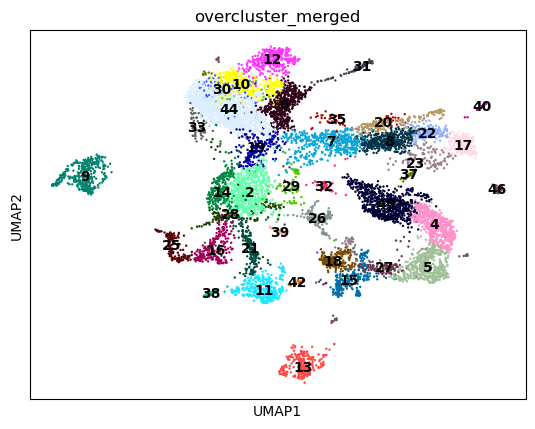

In [34]:
sc.pl.umap(adata, color="overcluster_merged", legend_loc='on data')

In [35]:
sc.tl.paga(adata, groups="overcluster_merged")

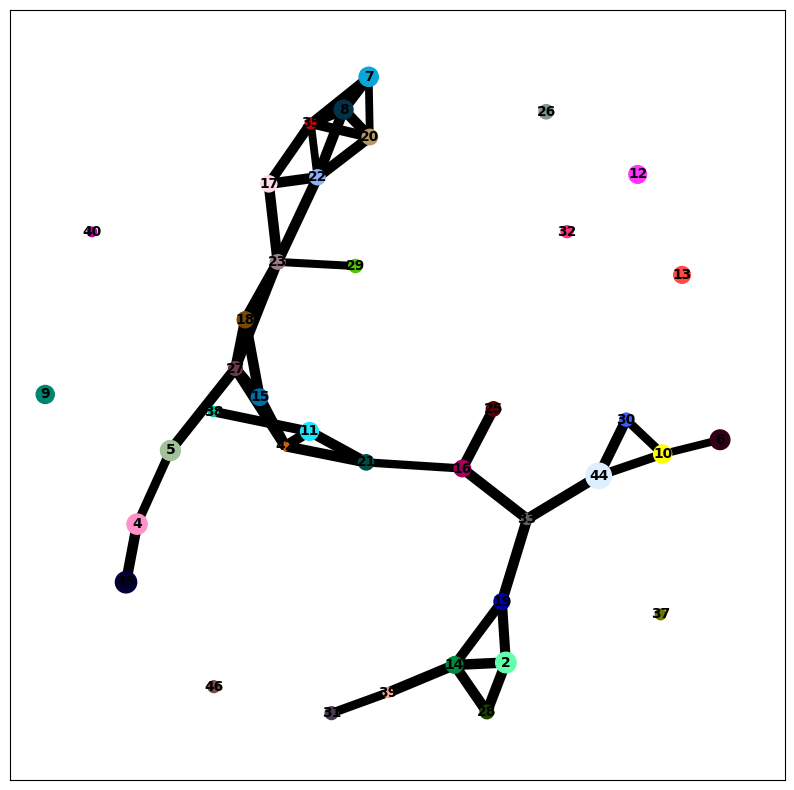

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.paga(adata, threshold=0.7, ax=ax)

We now are going to calculate a cell type tree for the merged clusters:

In [27]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)

ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
library(stats)
library(ape)

Prepare the distance matrix to be used for calculating cell type similarity. Remember to subset to only use the highly variable genes, to stay consistent with the rest of the analysis:

In [29]:
hvg = adata[:, adata.var["highly_variable"]]
log_norm = cluster.grouped_obs_mean(hvg, "overcluster_merged")

In [30]:
%%R -i log_norm
distance_matrix <- dist(t(log_norm), method = "euclidean")
nj.tree <- nj(distance_matrix)

nj.boot.tree <- boot.phylo(nj.tree, t(log_norm), FUN = function(x) nj(dist(x)), B = 1000)

Running bootstraps:       100 / 1000 200 / 1000 300 / 1000 400 / 1000 500 / 1000 600 / 1000 700 / 1000 800 / 1000 900 / 1000 1000 / 1000
Calculating bootstrap values... done.


In [31]:
%%R
nj.tree$node.label <- round(nj.boot.tree / 10)

nj.tree$edge.length <- sqrt(nj.tree$edge.length)

node_col <- nj.tree$node.label
node_col[nj.tree$node.label >= 80] <- "black"
node_col[nj.tree$node.label < 80] <- "yellow"
node_col[nj.tree$node.label < 50] <- "red"

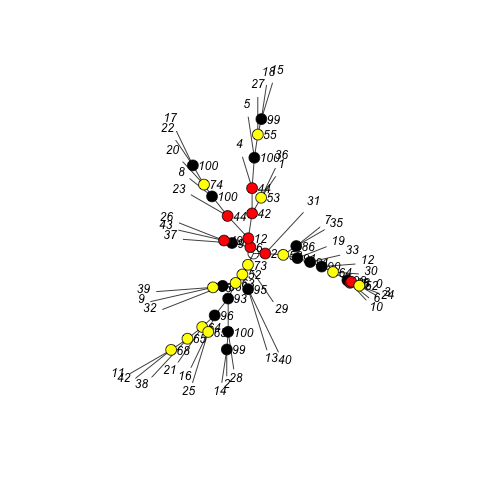

In [32]:
%%R
plot.phylo(nj.tree, type = "unrooted", show.node.label = TRUE, label.offset=0.3)
for (i in 1:length(node_col)) {
    nodelabels(node = length(nj.tree$tip.label)+i, pch=21, col="black", bg=node_col[i], cex=2)
}

 ### 4. Identifying the clusters

 We are going to look at the top DE genes for every cluster and try to assign a function to each of them.

In [ ]:
sc.tl.rank_genes_groups(adata,
                        groupby="overcluster_merged",
                        use_raw=True,
                        method="t-test_overestim_var")

In [ ]:
sc.tl.filter_rank_genes_groups(adata)

We are going to start with cluster 22, as it might be easier to identify:

In [ ]:
def keep_not_nan(x, how_many=50):
    keep = np.array([type(gene) is str for gene in x])
    return x[keep][:50]

In [ ]:
cl22_genes = adata.uns["rank_genes_groups"]["names"]["22"][:50]
cl22_filtered = adata.uns["rank_genes_groups_filtered"]["names"]["22"][:200]
cl22_filtered = keep_not_nan(cl22_filtered)

In [ ]:
sc.pl.dotplot(adata, cl22_filtered, groupby="overcluster_merged", swap_axes="true", cmap="magma_r")